## Import dependencies

## Load the data file 
this contains all the words used in the game 

In [3]:
sample_df = pd.read_csv("../data/connector_final.csv")
indices = sample_df.index
print(sample_df.head())

       Word  Occurrences  Length  LgSUBTLWF
0         a          4.0       1      6.018
1  aardvark          NaN       8      1.000
2    abacus          1.0       6      1.114
3   abandon          1.0       7      2.617
4     abbey          1.0       5      2.212


## Load vector embeddings 
We create numpy arrays for all the different representations

In [5]:
##Read in GLoVe embeddings
glovearray = read_vecs("../data/swow12217_glove2017wiki_vectors.csv")

##Read in SWOW embeddings
swowarray = read_vecs("../data/SWOW_R123_rw_k300.csv")

##Read in BERT embeddings
bert_sumarray = read_vecs("../data/bert_contextfree_sum.csv")

Normalize these embeddings and create a similarity matrix of these vectors 

In [6]:
def create_similarity_matrix(matrix, vector, N):
    matrix = 1-scipy.spatial.distance.cdist(matrix, vector, 'cosine').reshape(-1)
    matrix = matrix.reshape((N,N))
    matrix = stats.zscore(matrix, axis=1)
    return matrix

Now we can run this function for each of the embeddings arrays, for example here with GLoVe embeddings

In [7]:
sim_matrix_glove = create_similarity_matrix(glovearray, glovearray, glovearray.shape[0])

## Load in the raw data 
This is the empirical data from the experiments

In [17]:
e1e2_data = pd.read_csv("../data/raw_data.csv")[["Subject", "Trial", "Board", "Word1", "Word2", "Clue1", "P2W1", "P2W2",  "Clue2", "Player2SecondAnswer.RESP", "Clue3", "Player2ThirdAnswer.RESP", "Player1.RT", "Player1SecondClue.RT"]]
e1e2_data[['P2_Attempt2_W1','P2_Attempt2_W2']] = e1e2_data['Player2SecondAnswer.RESP'].str.split('{-}',expand=True)
e1e2_data[['P2_Attempt3_W1','P2_Attempt3_W2']] = e1e2_data['Player2ThirdAnswer.RESP'].str.split('{-}',expand=True)
e1e2_data.loc["Word1"] = e1e2_data["Word1"].str.lower()
e1e2_data.loc["Word2"] = e1e2_data["Word2"].str.lower()
e1e2_data.loc["Clue1"] = e1e2_data["Clue1"].str.lower()
e1e2_data.loc["Clue2"] = e1e2_data["Clue2"].str.lower()
e1e2_data.loc["Clue3"] = e1e2_data["Clue3"].str.lower()

Let us calculate cosine similarity between different words (Word pairs and clues provided)

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'
def calculate_cosine(row, index, array, sim_matrix, which):
    word1 = row['Word1']
    word2 = row['Word2']
    c1 = row['Clue1'].split('_')[0]
    c2 = row['Clue2']
    r1 = row['P2W1'] 
    r2 = row['P2W2']

    if which == 'bert_cat':
        n = 3072 
    elif which == 'bert_sum':
        n = 768
    elif which == 'swow':
        n = 299
    else:
        n = 300

    w = [word1, word2, c1, c2, r1, r2]
    word_indices2 =  np.empty(6)
    word_indices2[:] = np.nan
    word_indices2 = word_indices2.astype(object)

    for z in range(len(w)):
        final_df = sample_df[sample_df['Word'].isin([w[z]])]
        if len(final_df) > 0 :
            word_indices2[z] = list(final_df.index)[0]

    if np.isnan(word_indices2[0]) == False and np.isnan(word_indices2[1]) == False and np.isnan(word_indices2[2]) == False:
        worda_vector = array[word_indices2[0]]
        wordb_vector = array[word_indices2[1]]
        clue1_vector = array[word_indices2[2]]

        ##create a new vector by adding word1 and word2 vectos 
        sum_vector = (worda_vector + wordb_vector)
        sum_vector = sum_vector.reshape((1,n))
        ##calculate a normalized similarity matrix between the new vector and the array
        sum_sim_matrix = 1-scipy.spatial.distance.cdist(array, sum_vector, 'cosine').reshape(-1)
        sum_sim_matrix = stats.zscore(sum_sim_matrix)
        
        ##create a new column in the dataframe based on which vector embeddings you are using 
        ##this column will tell the cosine similarity between Word1+Word2 average vector and Clue1 
        col = 'w1w2_c1' + '_' + str(which)
        e1e2_data[col][index] = float(sum_sim_matrix[word_indices2[2]])

    # Let us look at Clue2
    # Now let us create an average vector with Word1, Word2 and Clue1 
    if np.isnan(word_indices2[3]) == False:
        sum_vector2 = (worda_vector + wordb_vector + clue1_vector)
        sum_vector2 = sum_vector2.reshape((1,n))
        sum_sim_matrix2 = 1-scipy.spatial.distance.cdist(array, sum_vector2, 'cosine').reshape(-1)
        sum_sim_matrix2 = stats.zscore(sum_sim_matrix2)
        ##this column will tell the cosine similarity between Word1+Word2 average vector and Clue2
        col = 'w1w2_c2' + '_' + str(which)
        e1e2_data[col][index] = float(sum_sim_matrix[word_indices2[3]])
        ##this column will tell the cosine similarity between Word1+Word2+Clue1 average vector and Clue2
        col = 'w1w2c1_c2' + '_' + str(which)
        e1e2_data[col][index] = float(sum_sim_matrix2[word_indices2[3]])

    d_w1 = []
    d_w2 = []
    d_c1 =[]
    d_c2 =[]
    d_r1 = []
    d_r2 = []
      ##let us calculate cosine between w1 and w2
    col = 'w1w2' + '_' + str(which)
    if (np.isnan(word_indices2[0]) == False) and (np.isnan(word_indices2[1]) == False):
        w1w2 = sim_matrix[word_indices2[0],word_indices2[1]]

        e1e2_data[col][index] = float(w1w2)
    else :
    
        e1e2_data[col][index] = np.nan
    ##let us calculate cosine between clue1 and clue2
    col = 'c1c2' + '_' + str(which)
    if (np.isnan(word_indices2[2]) == False) and (np.isnan(word_indices2[3]) == False):
        w1w2 = sim_matrix[word_indices2[2],word_indices2[3]]
    
        e1e2_data[col][index] = float(w1w2)
    else :
        e1e2_data[col][index] = np.nan

    ##let us calculate cosine between word1 and c1 
    col = 'w1c1' + '_' + str(which)
    if (np.isnan(word_indices2[0]) == False) and (np.isnan(word_indices2[2]) == False):
        w1w2 = sim_matrix[word_indices2[0],word_indices2[2]]

        e1e2_data[col][index] = float(w1w2)
    else :
        e1e2_data[col][index] = np.nan
  
    #let us calculate cosine between word1 and clue2 
    col = 'w1c2' + '_' + str(which)
    if (np.isnan(word_indices2[0]) == False) and (np.isnan(word_indices2[3]) == False):
        w1w2 = sim_matrix[word_indices2[0],word_indices2[3]]
        e1e2_data[col][index] = float(w1w2)
    else :
        e1e2_data[col][index] = np.nan

##let us calculate cosine between word2 and clue1 
    col = 'w2c1' + '_' + str(which)
    if (np.isnan(word_indices2[1]) == False) and (np.isnan(word_indices2[2]) == False):
        w1w2 = sim_matrix[word_indices2[1],word_indices2[2]]
        e1e2_data[col][index] = float(w1w2)
    else :
        e1e2_data[col][index] = np.nan

###let us calculate cosine between word2 and clue2
    col = 'w2c2' + '_' + str(which)
    if (np.isnan(word_indices2[1]) == False) and (np.isnan(word_indices2[3]) == False):
        w1w2 = sim_matrix[word_indices2[1],word_indices2[3]]

        e1e2_data[col][index] = float(w1w2)
    else :
        e1e2_data[col][index] = np.nan

    ###let us calculate cosine between the guesser responses (r1, r2) and word pair (w1, w2) 
    if which == 'glove' :
        if (np.isnan(word_indices2[0]) == False) and (np.isnan(word_indices2[4]) == False):
            r1_w1 = sim_matrix[word_indices2[0],word_indices2[4]]
            col = 'r1w1' + '_' + str(which)
            e1e2_data[col][index] = float(r1_w1)
        else :
            e1e2_data[col][index] = np.nan
        
        if (np.isnan(word_indices2[1]) == False) and (np.isnan(word_indices2[5]) == False):
            r2_w2 = sim_matrix[word_indices2[1],word_indices2[5]]
            col = 'r2w2' + '_' + str(which)
            e1e2_data[col][index] = float(r2_w2)
        else :
            e1e2_data[col][index] = np.nan
        
        if (np.isnan(word_indices2[1]) == False) and (np.isnan(word_indices2[4]) == False):
            r1_w2 = sim_matrix[word_indices2[1],word_indices2[4]]
            col = 'r1w2' + '_' + str(which)
            e1e2_data[col][index] = float(r1_w2)
        else :
            e1e2_data[col][index] = np.nan
        
        if (np.isnan(word_indices2[0]) == False) and (np.isnan(word_indices2[5]) == False):
            r2_w1 = sim_matrix[word_indices2[0],word_indices2[5]]
            col = 'r2w1' + '_' + str(which)
            e1e2_data[col][index] = float(r2_w1)
        else :
            e1e2_data[col][index] = np.nan

In [ ]:
for i in ['glove', 'bert_sum', 'swow']:
    p = 'w1w2' + '_' + i
    e1e2_data[p] = ""
    p = 'c1c2' + '_' + i
    e1e2_data[p]= ""
    p = 'w1c1' + '_' + i
    e1e2_data[p]= ""
    p = 'w1c2' + '_' + i
    e1e2_data[p]= ""
    p = 'w2c1' + '_' + i
    e1e2_data[p]= ""
    p = 'w2c2' + '_' + i
    e1e2_data[p]= ""
    p = 'w1w2_c1' + '_' + i
    e1e2_data[p]= ""
    p = 'w1w2_c2' + '_' + i
    e1e2_data[p]= ""
    p = 'w1w2c1_c2' + '_' + i
    e1e2_data[p]= ""
    p = 'r1w1' + '_' + i 
    e1e2_data[p]= ""
    p = 'r1w2' + '_' + i 
    e1e2_data[p]= ""
    p = 'r2w1' + '_' + i 
    e1e2_data[p]= ""
    p = 'r2w2' + '_' + i 
    e1e2_data[p]= ""

    print(i)
    arr = i+'array'
    mat = 'sim_matrix' + '_' + i
    for index, row in e1e2_data.iterrows():
        if pd.isna(row['Clue1']) == False :
            similarity_forboard(row, index, eval(arr), eval(mat), i)


Divide word pairs based on their cosine category, as low and high based on their medians:

In [ ]:
e1e2_data['w1w2_bert_sum'].median(), e1e2_data['w1w2_glove'].median(), e1e2_data['w1w2_swow'].median()

In [ ]:
e1e2_data['cosine_category_bert_sum'] = e1e2_data.apply(lambda x: 'Low' if  x['w1w2_bert_sum'] <= 0.63 else 'High' , axis=1)
e1e2_data['cosine_category_swow'] = e1e2_data.apply(lambda x: 'Low' if  x['w1w2_swow'] <= -0.18 else 'High' , axis=1)
e1e2_data['cosine_category_glove'] = e1e2_data.apply(lambda x: 'Low' if  x['w1w2_glove'] <= 0.91 else 'High' , axis=1)

Let us add in columns regarding Guessed and Unguessed words for Clue2

In [ ]:
e1e2_data['guessedwordc1'] = ""
e1e2_data['unguessedwordc1'] = ""
e1e2_data['guessedwordc2'] = ""
e1e2_data['unguessedwordc2'] = ""
e1e2_data['onewordguessed'] = ""
pd.options.mode.chained_assignment = None  # default='warn'

for j in ['glove', 'swow', 'bert_sum'] : 
    e1e2_data['guessedwordc1_'+j] = ""
    e1e2_data['unguessedwordc1_'+j] = ""
    e1e2_data['guessedwordc2_'+j] = ""
    e1e2_data['unguessedwordc2_'+j] = ""
    for index,row in e1e2_data.iterrows() :
      # if (row['r1w1_glove'] == 1) or (row['r2w1_glove'] == 1):
        if (row['Word1'] == row['P2W1']) or (row['Word1'] == row['P2W2']) :
            if (row['Word2'] != row['P2W1']) and (row['Word2'] != row['P2W2']):
                e1e2_data['onewordguessed'][index] = 'Yes'
                if np.isnan(row['w1c1_'+j]) == False:
                    e1e2_data['guessedwordc1_'+j][index] = float(row['w1c1_'+j])
                if np.isnan(row['w2c1_'+j]) == False:
                    e1e2_data['unguessedwordc1_'+j][index] = float(row['w2c1_'+j])
                if np.isnan(row['w1c2_'+j]) == False:
                    e1e2_data['guessedwordc2_'+j][index] = float(row['w1c2_'+j])
                if np.isnan(row['w2c2_'+j]) == False:
                    e1e2_data['unguessedwordc2_'+j][index] = float(row['w2c2_'+j])

        elif (row['Word2'] == row['P2W1']) or (row['Word2'] == row['P2W2']) :
            if (row['Word1'] != row['P2W1']) and (row['Word1'] != row['P2W2']):
                e1e2_data['onewordguessed'][index] = 'Yes'
                if np.isnan(row['w1c1_'+j]) == False:
                    e1e2_data['unguessedwordc1_'+j][index] = float(row['w1c1_'+j])
                if np.isnan(row['w2c1_'+j]) == False:
                    e1e2_data['guessedwordc1_'+j][index] = float(row['w2c1_'+j])
                if np.isnan(row['w1c2_'+j]) == False:
                    e1e2_data['unguessedwordc2_'+j][index] = float(row['w1c2_'+j])
                if np.isnan(row['w2c2_'+j]) == False:
                    e1e2_data['guessedwordc2_'+j][index] = float(row['w2c2_'+j])

        if ((row['Word2'] != row['P2W1']) 
            and (row['Word2'] != row['P2W2']) 
            and (row['Word1'] == row['P2W1']) 
            and (row['Word1'] == row['P2W2'])):
            e1e2_data['onewordguessed'][index] = 'No'

We can save this dataframe now 

In [ ]:
e1e2_data = e1e2_data.replace(r'^\s*$', np.nan, regex=True)
e1e2_data.to_csv("../data/e1e2_allvectors_znorm.csv")

To make figures, we can create a new dataframe from this one 

In [21]:
clue=[]
word1=[]
word2=[]
w1w2=[]
category=[]
guessed=[]
w1_w2 = []
id = []
c1c2=[]
vector = []

for index,row in e1e2_data.iterrows() :
    for j in ['glove', 'swow', 'bert_sum'] :
        # for k in ['Low', 'High']
        clue.append('Clue1')

        word1.append(row['w1c1_'+j])
        word2.append(row['w2c1_'+j])
        w1w2.append(row['w1w2_c1_'+j])
        category.append(row['cosine_category_'+j])
        # guessed.append(row['onewordguessed'])
        # if row['cosine_category_'+j] == 'Low':
          # vector.append(j+'low')
        # elif row['cosine_category_'+j] == 'High':
          # vector.append(j+'high')
        vector.append(j)
        w1_w2.append(np.nan)
        id.append(index)
        c1c2.append(np.nan)

        clue.append('Clue2')
        word1.append(row['w1c2_'+j])
        word2.append(row['w2c2_'+j])
        w1w2.append(row['w1w2_c2_'+j])
        category.append(row['cosine_category_'+j])
        # guessed.append(row['onewordguessed'])
        w1_w2.append(row['w1w2c1_c2_'+j])
        c1c2.append(row['c1c2_'+j])
        vector.append(j)
        # if row['cosine_category_'+j] == 'Low':
        #   vector.append(j+'low')
        # elif row['cosine_category_'+j] == 'High':
        #   vector.append(j+'high')
        id.append(index)

for_plots = pd.DataFrame({'Clue': clue, 'Vector':vector, 'c1c2':c1c2, 'Word1': word1, 'Word2': word2, 'Word1-Word2 Avg': w1w2, 'W1-W2 Cosine':category, 'w1w2c1':w1_w2, 'id':id})
for_plots.head()

,Clue,Vector,c1c2,Word1,Word2,Word1-Word2 Avg,W1-W2 Cosine,w1w2c1,id
0,Clue1,glove,NaN,0.140821,2.990684,1.843219,Low,NaN,0
1,Clue2,glove,0.665793,2.023770,0.992467,2.032058,Low,1.578827,0
2,Clue1,swow,NaN,-0.135192,-0.635905,-0.581890,High,NaN,0
3,Clue2,swow,0.060962,-0.513553,-0.445894,-0.651236,High,-0.514006,0
4,Clue1,bert_sum,NaN,0.745487,1.188064,1.047613,Low,NaN,0


In [22]:
df = for_plots.melt(id_vars=["Clue", "Vector", "W1-W2 Cosine",  "id", "c1c2", "w1w2c1"])
df.head()

,Clue,Vector,W1-W2 Cosine,id,c1c2,w1w2c1,variable,value
0,Clue1,glove,Low,0,NaN,NaN,Word1,0.140821
1,Clue2,glove,Low,0,0.665793,1.578827,Word1,2.023770
2,Clue1,swow,High,0,NaN,NaN,Word1,-0.135192
3,Clue2,swow,High,0,0.060962,-0.514006,Word1,-0.513553
4,Clue1,bert_sum,Low,0,NaN,NaN,Word1,0.745487


<Figure size 864x576 with 0 Axes>

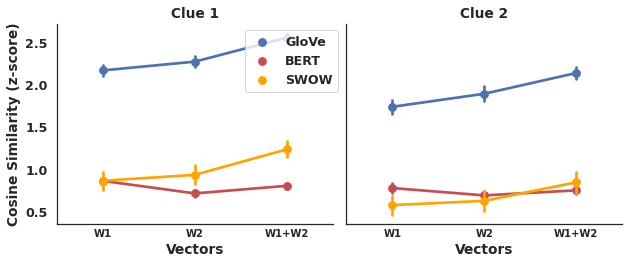

In [23]:
sns.set(font_scale= 1.15)
plt.figure(figsize=(12,8))

sns.set_style("white")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
o = ['glove', 'bert_sum', 'swow']

g = sns.catplot(data=df, x='variable', y='value', col='Clue', style = 'W1-W2 Cosine', hue='Vector',  kind='point', palette={'glove':'b', 'bert_sum':'r', 'swow':'orange'}, height=4, aspect=1.15, legend=False, sharex=False, hue_order = o  )
g.set_ylabels('Cosine Similarity (z-score)')
g.fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.05)
plt.legend(loc='upper left')

g.set_axis_labels('Vectors')
g.axes[0,0].set_xticklabels(["W1", "W2", "W1+W2"],  va="center", fontsize="10")
g.axes[0,1].set_xticklabels(["W1", "W2", "W1+W2", "W1+W2+C1"],  va="center", fontsize="10")
axes = g.axes.flatten()
axes[0].set_title("Clue 1", weight='bold')
axes[1].set_title("Clue 2", weight='bold')

L=plt.legend(frameon=True, loc='upper center', bbox_to_anchor=(-0.2,1))
L.get_texts()[0].set_text('GloVe')
L.get_texts()[1].set_text('BERT')
L.get_texts()[2].set_text('SWOW')